In [ ]:
import torch
import gpytorch
import numpy as np
from scipy import stats
from joblib import Parallel, delayed
from multiprocessing import cpu_count
import os
import numpy as np
import matplotlib.pyplot as plt
import emcee
import numpy.linalg as la
from getdist import plots, MCSamples, parampriors
from joblib import Parallel, delayed, cpu_count
from multiprocessing import cpu_count, Pool
import time

# **BIN 5**

## Datavectors

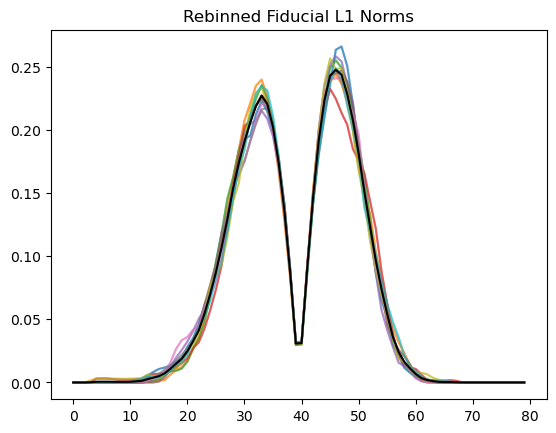

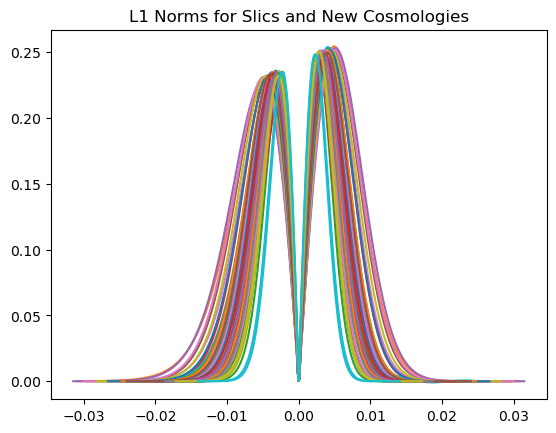

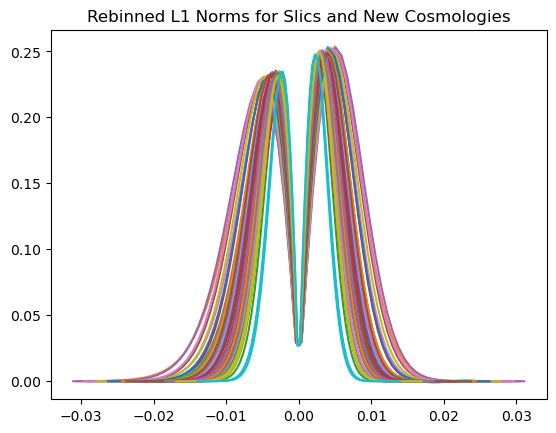

In [75]:
# LOAD FIDUCIAL
fid = np.load('/Users/atersenov/Data/l1_validation/sim_datavectors/bin5/fid_a/new_l1_norms_fid_a_f_theta15.0_bin5.npy', allow_pickle=True)
# fid = np.load('/Users/atersenov/Data/l1_validation/sim_datavectors/bin5/fid_a/new_l1_norms_fid_a_theta15.0_bin5.npy', allow_pickle=True)
rebinning_factor = 10
fid_rebinned = fid.reshape(fid.shape[0], -1, rebinning_factor).mean(axis=2)
fid_rebinned_mean = fid_rebinned.mean(axis=0)
plt.figure()
for i in range(fid_rebinned.shape[0]):
    plt.plot(fid_rebinned[i], alpha=0.5)
plt.plot(fid_rebinned_mean, label='Mean', color='k')
plt.title('Rebinned Fiducial L1 Norms')
plt.show()
# LOAD THEORY PREDICTIONS

cosmo_slics = np.load('/Users/atersenov/Downloads/filtertophat_results_15_tomobin5_simulationTrue.npy', allow_pickle=True).item()
cosmo_new = np.load('/Users/atersenov/Downloads/filtertophat_results_15_tomobin5_simulationFalse.npy', allow_pickle=True).item()
# Extract all slics arrays into a list
slics_l1 = [cosmo_slics[i]['prediction_l1'] for i in range(len(cosmo_slics))]
sim = [cosmo_slics[i]['sim_l1_runs'] for i in range(len(cosmo_slics))]
slics_sigma = [cosmo_slics[i]['perturbation_theory_sigma_sq'] for i in range(len(cosmo_slics))]
snr = cosmo_slics[0]['snr'] 

# Extract all new arrays into a list
new_l1 = [cosmo_new[i]['prediction_l1'] for i in range(len(cosmo_new))]
new_sigma = [cosmo_new[i]['perturbation_theory_sigma_sq'] for i in range(len(cosmo_new))]
# Convert to a NumPy array
slics_l1 = np.stack(slics_l1)  
sim = np.stack(sim)
slics_sigma = np.stack(slics_sigma)
new_l1 = np.stack(new_l1)
new_sigma = np.stack(new_sigma)
sim_std_per_cosmo = np.std(sim, axis=1)
#  calculate the variance of the slics_l1
sim_slics_variance = np.var(sim, axis=1)
plt.figure()
for i in range(slics_l1.shape[0]):
    plt.plot(snr * np.sqrt(slics_sigma[i]), slics_l1[i], label=f'Slics {i+1}')
for i in range(new_l1.shape[0]):
    plt.plot(snr * np.sqrt(new_sigma[i]), new_l1[i], label=f'New {i+1}')
plt.title('L1 Norms for Slics and New Cosmologies')
plt.show()


# REBINNING

slics_l1_rebinned = slics_l1.reshape(slics_l1.shape[0], -1, rebinning_factor).mean(axis=2)
snr_rebinned = snr.reshape(-1, rebinning_factor).mean(axis=1)

new_l1_rebinned = new_l1.reshape(new_l1.shape[0], -1, rebinning_factor).mean(axis=2)
plt.figure()
for i in range(slics_l1_rebinned.shape[0]):
    plt.plot(snr_rebinned * np.sqrt(slics_sigma[i]), slics_l1_rebinned[i], label=f'Prediction {i+1}')
for i in range(new_l1_rebinned.shape[0]):
    plt.plot(snr_rebinned * np.sqrt(new_sigma[i]), new_l1_rebinned[i], label=f'Prediction {i+1}')
plt.title('Rebinned L1 Norms for Slics and New Cosmologies')
plt.show()

## Covariance

Load datavectors

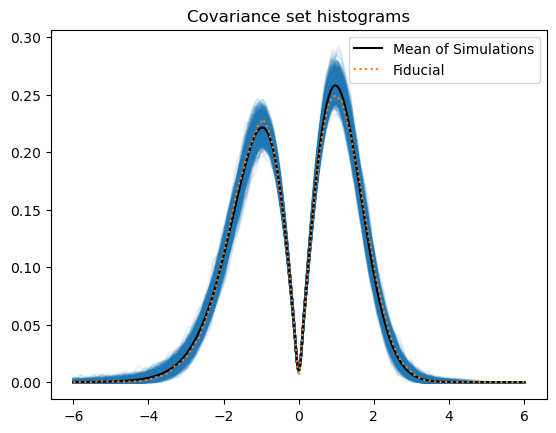

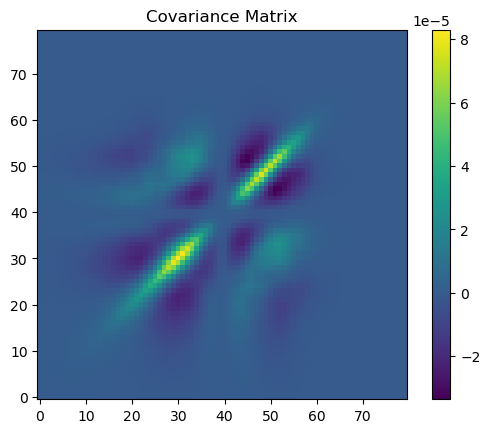

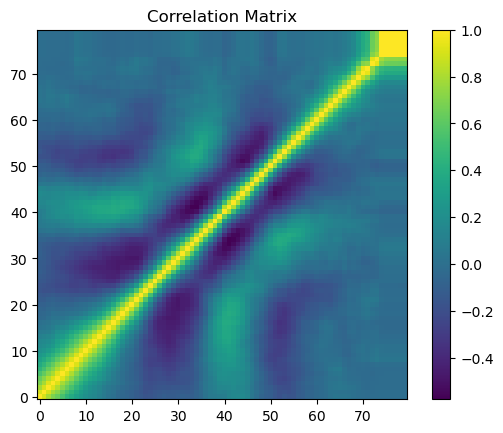

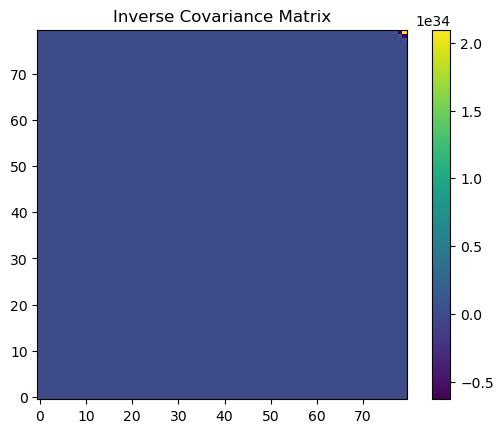

(80,)

In [76]:
cov_l1_dv = np.load('/Users/atersenov/Downloads/new_cov_l1_norms_theta15.0_bin5.npy', allow_pickle=True)
cov_sigma = np.load('/Users/atersenov/Downloads/new_cov_sigma_values_theta15.0_bin5.npy', allow_pickle=True)

plt.figure()
for i in range(cov_l1_dv.shape[0]):
    plt.plot(snr , cov_l1_dv[i], color='C0', alpha=0.1)
plt.plot(snr , np.mean(cov_l1_dv, axis=0), label='Mean of Simulations',  color='black')
plt.plot(snr, np.mean(fid, axis=0), label='Fiducial', color='C1', ls=':',)
plt.title('Covariance set histograms')
plt.legend()
plt.show()

# REBINNING COVARIANCE MATRICES
cov_l1_dv_rebinned = cov_l1_dv.reshape(cov_l1_dv.shape[0], -1, rebinning_factor).mean(axis=2)
rebinned_snr = snr.reshape(-1, rebinning_factor).mean(axis=1)

# CALCULATE COVARIANCE AND CORRELATION MATRICES
covariance_matrix = np.cov(cov_l1_dv_rebinned, rowvar=False)
correlation_matrix = np.corrcoef(cov_l1_dv_rebinned, rowvar=False)

plt.figure()
plt.imshow(covariance_matrix, cmap='viridis', interpolation='nearest', origin='lower')
plt.colorbar()
plt.title('Covariance Matrix')
plt.show()

plt.figure()
plt.imshow(correlation_matrix, cmap='viridis', interpolation='nearest', origin='lower')
plt.colorbar()
plt.title('Correlation Matrix')
plt.show()

# INVERSE COVARIANCE MATRIX
cov = covariance_matrix
icov = la.inv(cov)

plt.figure()
plt.imshow(icov, origin='lower') #, vmin=0,vmax=5000)
plt.colorbar()
plt.title('Inverse Covariance Matrix')
plt.show()

# DIAGONAL OF THE COVARIANCE MATRIX
cov_diag = np.diag(cov)
cov_diag.shape

# GPR

## Creating arrays for cosmological parameters and l1 data vectors

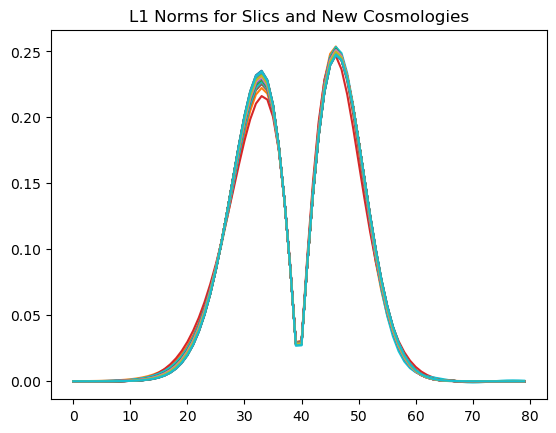

0.1019 0.5482
0.6034 0.8129
-1.9866 -0.5223
0.4716 1.3428


In [77]:
# SLICS COSMOLOGIES

# Read the CosmoTable.dat and parse into a dictionary
cosmo_table_path = './../example/CosmoTable.dat'
cosmo_params = {}

with open(cosmo_table_path, 'r') as file:
    lines = file.readlines()[1:]  # Skip the header

for line in lines:
    parts = line.split()
    cosmo_id = int(parts[0])
    # ignore the last column (i.e. the Oc parameter)
    parameters = [float(param) for param in parts[1:]]
    cosmo_params[cosmo_id] = parameters

# Initialize the params array based on the cosmo_params dictionary
params = np.array([cosmo_params[cosmo_id] for cosmo_id in range(25)])
# remove last column (that corresponds to Oc)
params = params[:,:-1]


# NEW COSMOLOGIES

# Desired parameter order
param_order = ["Om", "h", "w", "sigma8"]

# Extract parameters into a list of lists
params_new = np.array([
    [float(entry["cosmology"][param]) for param in param_order]
    for entry in cosmo_new.values()
])

# CONCATENATE SLICS AND NEW COSMOLOGIES

params_full = np.concatenate((params, params_new), axis=0)
l1_rebinned = np.concatenate((slics_l1_rebinned, new_l1_rebinned), axis=0)
plt.figure()
for i in range(50):
    plt.plot(l1_rebinned[i], label=f'Prediction {i+1}')
plt.title('L1 Norms for Slics and New Cosmologies')
plt.show()

# PRINT PARAMETER RANGES
print(params[:,0].min(),params[:,0].max())
print(params[:,1].min(), params[:,1].max())
print(params[:,2].min(), params[:,2].max())
print(params[:,3].min(), params[:,3].max())

## GPyTorch

In [ ]:
# Function to train the GP for a specific bin
def gp_train_small(index_bin, params_train, obs_train):
    obs_bin = obs_train[:, index_bin]
    
    # Data scaling factor
    scaling = np.mean(obs_bin)
    if scaling == 0 or np.isnan(scaling):
        raise ValueError("Scaling factor is zero or NaN.")
    
    # Scale the data values
    obs_bin /= scaling
    
    # Convert to torch tensors
    train_x = torch.tensor(params_train, dtype=torch.float32)
    train_y = torch.tensor(obs_bin, dtype=torch.float32)
    
    # Initialize likelihood and model
    likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.GreaterThan(1e-6))
    model = ExactGPModel(train_x, train_y, likelihood)
    
    # Find optimal model hyperparameters
    model.train()
    likelihood.train()
    
    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.05)  # Includes GaussianLikelihood parameters
    
    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    
    training_iter = 100
    for i in range(training_iter):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()
    
    return model, scaling


# Parallel training for each bin
ncpu = cpu_count()
gp_scaling_mean = np.array([
    Parallel(n_jobs=ncpu, verbose=0)(
        delayed(gp_train_small)(index_bin, params_train=params_full, obs_train=l1_rebinned) 
        for index_bin in range(l1_rebinned.shape[1])
    )
]).reshape(l1_rebinned.shape[1], 2)

params_fiducial = np.array([0.2905, 0.6898, -1., 0.8364])
test_fid_mean = gp_predict(params_fiducial, gp_scaling_mean)

plt.figure()
plt.plot(np.sqrt(test_fid_mean[1]), label='GP error')
plt.plot(np.sqrt(np.diag(cov)), label='Cov error')
plt.legend()
plt.title('GP and Covariance Errors')
plt.show()

# plot in one subplot the real histograms for all the cosmologies and in another one the ones predicted by GPR
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
# for i in range(1116):
#     plt.plot(SS_PC_data_vectors[i][low_param_cut:param_cut], alpha=0.1, color='red')

for i in range(50):
    plt.plot(l1_rebinned[i], label=f'{i}', alpha=0.5)
plt.legend()
plt.grid()
plt.title('Real histograms for all the cosmologies')

plt.subplot(1,2,2)
for i in range(50):
    test_cosmo = gp_predict(params_full[i], gp_scaling_mean)
    plt.plot(test_cosmo[0], label=f'{i}', alpha=0.5)
plt.legend()
plt.grid()
plt.title('Predicted histograms for all the cosmologies')
plt.show()


# LIKELIHOOD FUNCTIONS
def lnlike_gpy(params, gp_scaling, l1_data, cov):
    # Predict using GP emulator
    predictions = gp_predict(params, gp_scaling)
    
    # Extract predicted means and variances
    pred_means = predictions[0]
    pred_vars = predictions[1]
    
    icov = np.linalg.inv(cov)
    
    # Compute the log-likelihood
    diff = l1_data - pred_means
    lnlikelihood = -0.5 * norm * np.dot(np.dot(diff.T, icov), diff)
    return lnlikelihood

def lnprior_gpy(params, Om_min, Om_max, h_min, h_max, w_0_min, w_0_max, sigma_8_min, sigma_8_max):
    Om, h, w0, sigma8 = params
    if Om_min < Om < Om_max and h_min < h < h_max and w_0_min < w0 < w_0_max and sigma_8_min < sigma8 < sigma_8_max:
        return 0.0
    return -np.inf

def lnpost_gpy(params, l1_data, cov, gp_scaling, Om_min, Om_max, h_min, h_max, w_0_min, w_0_max, sigma_8_min, sigma_8_max):
    lp = lnprior_gpy(params, Om_min, Om_max, h_min, h_max, w_0_min, w_0_max, sigma_8_min, sigma_8_max)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike_gpy(params, gp_scaling, l1_data, cov)


# PREDICT USING GP
gp_list = gp_scaling_mean[:, 0]
scaling = gp_scaling_mean[:, 1]
params_fiducial_without_Oc = np.array([0.2905, 0.6898, -1., 0.8364])
test_fid = gp_predict(params_fiducial_without_Oc, gp_scaling_mean)
# l1_data = l1_fid_mean
l1_data = test_fid[0]
n_real = 926
n_bins = len( test_fid[0])
norm = (n_real-n_bins-2)/(n_real-1)
print('norm=',norm)
Om_min = 0.1019
Om_max = 0.5482
h_min = 0.6034
h_max = 0.8129
w_0_min = -1.9866
w_0_max = -0.5223
sigma_8_min = 0.4716
sigma_8_max = 1.3428

# MCMC SAMPLING
import tqdm
ndim, nwalkers = 4, 16
test_init_params = np.array([0.33, 0.65, -1.5, 1.1])
pos = [test_init_params + 1e-3 * np.random.randn(ndim) for i in range(nwalkers)]

print(f"{ncpu} CPUs")

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnpost_gpy,
                                args=(l1_data, cov, gp_scaling_mean, Om_min, Om_max, h_min, h_max, w_0_min, w_0_max, sigma_8_min, sigma_8_max))
start = time.time()
sampler.run_mcmc(pos, 2000, progress=True)
end = time.time()
multi_time = end - start
print(f"Multiprocessing took {multi_time:.1f} seconds")

samples_sim = sampler.get_chain(discard=200, flat=True)
samples_sim = sampler.chain[:,200:, :].reshape((-1, ndim))
MC_samples_sim = MCSamples(samples=samples_sim,names = [r"$\Omega_{m}$",r"$h$", r"$w_0$", r"$\sigma_8$"], 
                                ranges={"$\Omega_m$":[0.1,0.54], "$h$":[0.6,0.8], "$w_0$":[-1.99,-0.2], "$\sigma_8$":[0.4,1.2]})

from getdist import plots, MCSamples, parampriors
truth_values = [0.2905, 0.6898, -1., 0.8364]

g = plots.get_subplot_plotter(width_inch=7)
g.settings.legend_fontsize = 15
g.settings.axes_fontsize = 15
g.settings.axes_labelsize = 15
g.settings.alpha_factor_contour_lines = 1
g.settings.figure_legend_frame = True

# Create the triangle plot
g.triangle_plot([MC_samples_sim], filled=True)

# Iterate over each subplot to add truth lines
for i, ax in enumerate(g.subplots.flatten()):
    if ax is not None:
        # Determine the position of the subplot in the triangle plot to decide on vertical or horizontal lines
        row, col = divmod(i, len(truth_values))
        if row > col:
            # For diagonal plots, add both vertical and horizontal lines as they represent one parameter against itself
            ax.axvline(truth_values[col], color='r', linestyle='--', linewidth=1)
            ax.axhline(truth_values[row], color='r', linestyle='--', linewidth=1)
        elif col == row:
            # For upper triangle, add vertical lines
            ax.axvline(truth_values[col], color='r', linestyle='--', linewidth=1)
        else:
            # For lower triangle, add horizontal lines
            ax.axhline(truth_values[row], color='r', linestyle='--', linewidth=1)


## Scikit-learn GPR

In [79]:
import numpy as np
import joblib
from sklearn.preprocessing import StandardScaler        # or MinMaxScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (
    ConstantKernel as C, RBF, WhiteKernel
)
from joblib import Parallel, delayed

X shape: (50, 4) , Y shape: (50, 80)


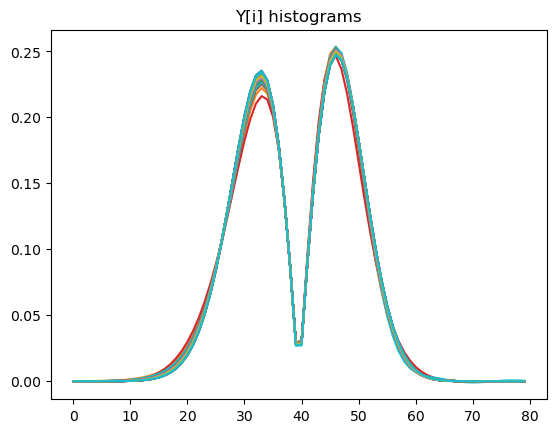

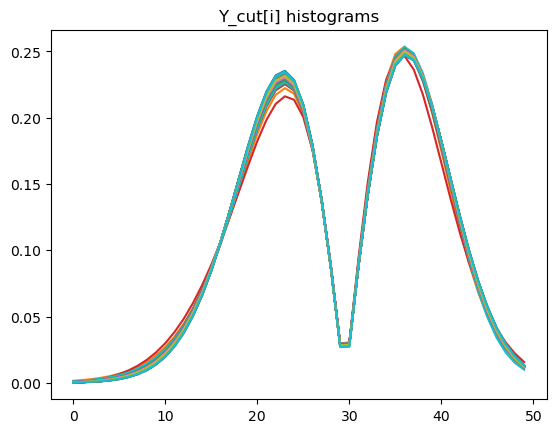

In [80]:
# 1. DATA PREPARATION

X = params_full.astype(float)        # (50, 4)
Y = l1_rebinned.astype(float)        # (50, 40)
noise_per_bin = np.sqrt(cov_diag).astype(float)  # (40,)
print('X shape:', X.shape, 
      ', Y shape:', Y.shape)

# 2. SCALE THE COSMOLOGICAL PARAMETERS
x_scaler = StandardScaler()
# x_scaler = MinMaxScaler(feature_range=(-1, 1))
X_scaled = x_scaler.fit_transform(X)

plt.figure()
for i in range(Y.shape[0]):
    plt.plot(Y[i])
plt.title('Y[i] histograms')
plt.show()

# CUT THE HISTOGRAMS

low_bin_cut = 10
up_bin_cut = 60
Y_cut = Y[:, low_bin_cut:up_bin_cut]

plt.figure()
for i in range(50):
    plt.plot(Y_cut[i], label=f'{i}')
plt.title('Y_cut[i] histograms')
plt.show()

noise_per_bin_cut = noise_per_bin[low_bin_cut:up_bin_cut]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  33 out of  50 | elapsed:    3.9s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  39 out of  50 | elapsed:    4.0s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  45 out of  50 | elapsed:    4.1s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    4.1s finished


1.48**2 * RBF(length_scale=[19.9, 2.13, 4.66, 0.607])


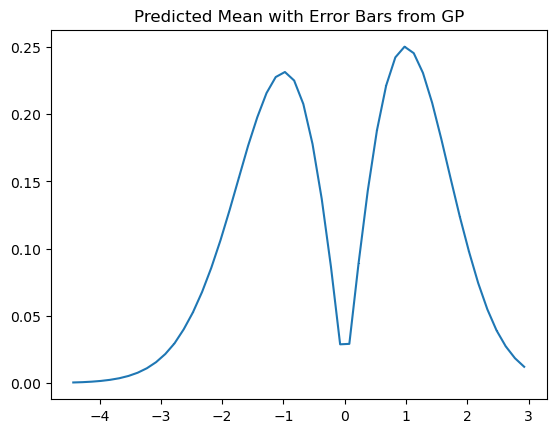

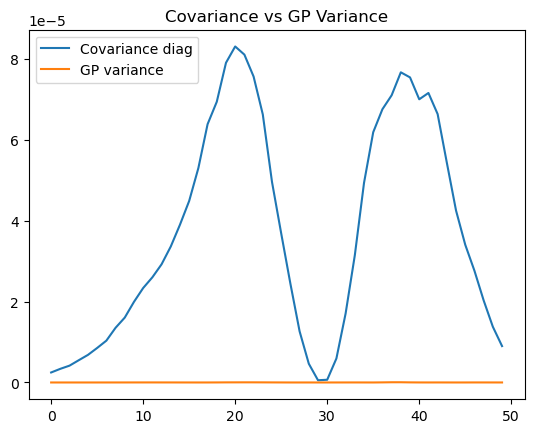

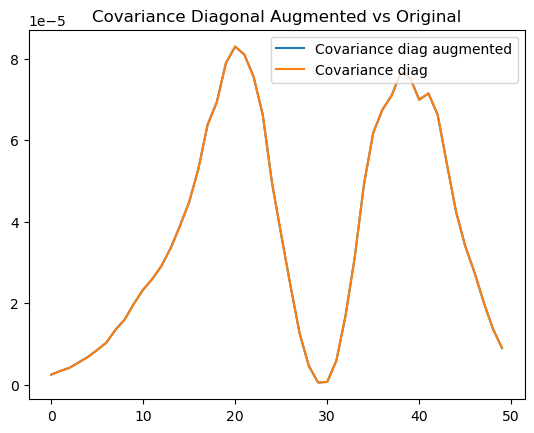

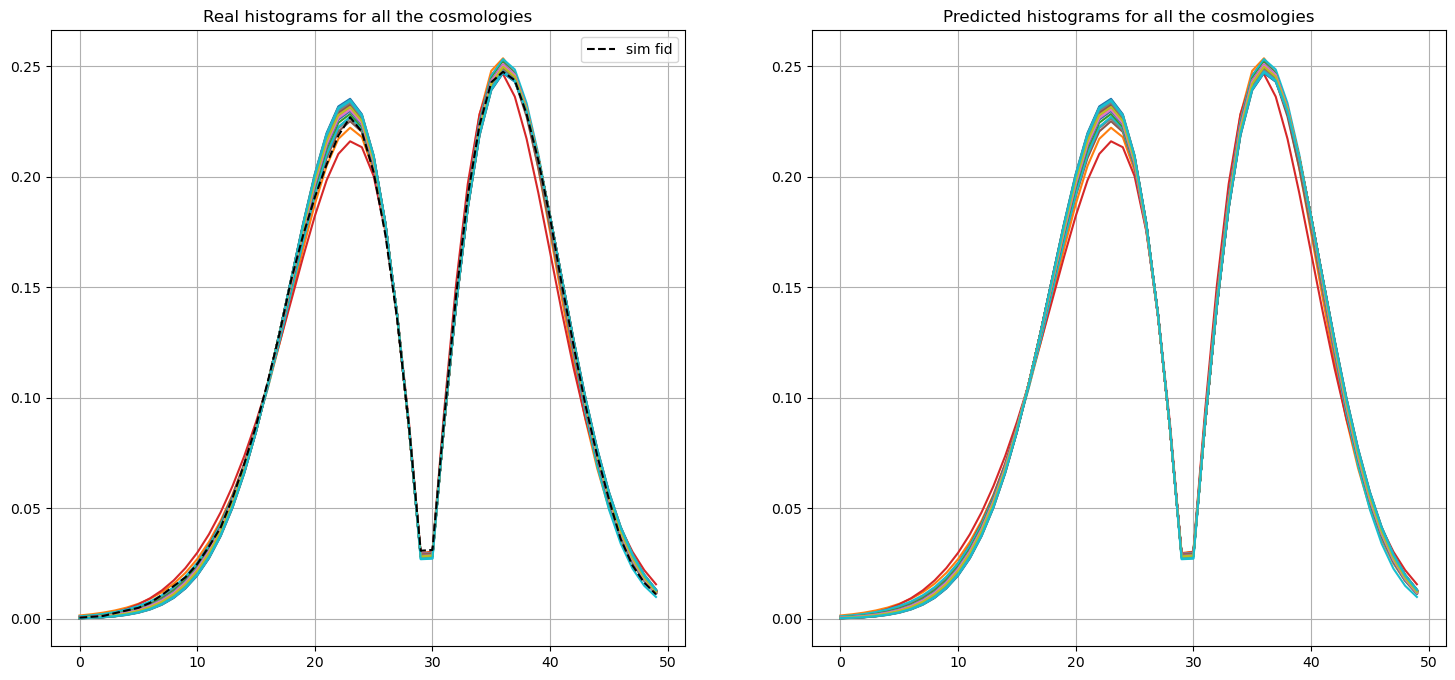

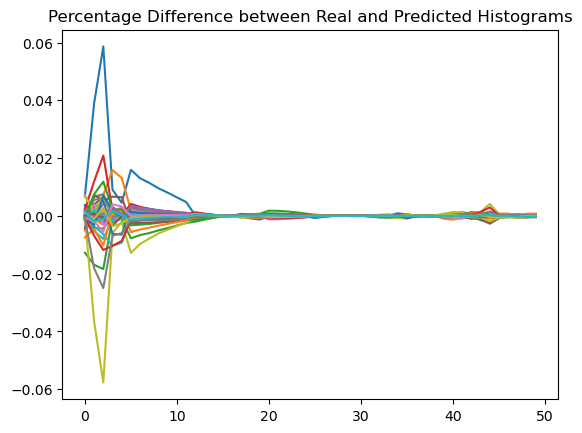

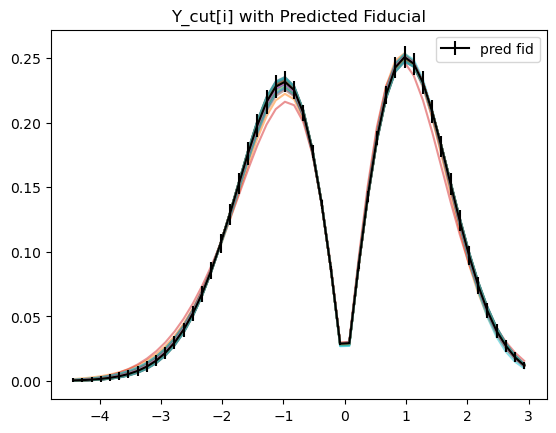

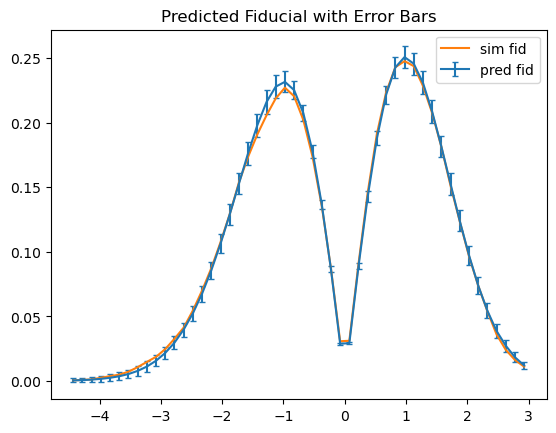

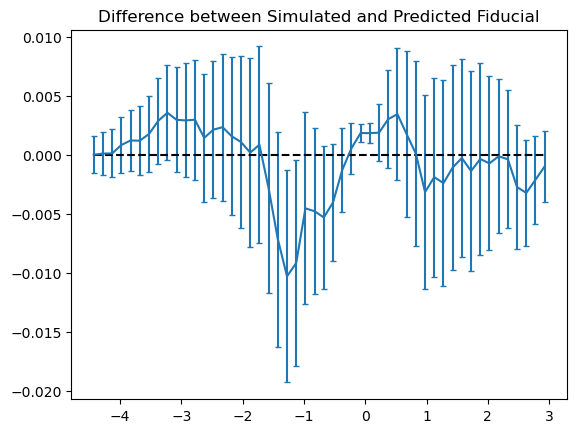

In [81]:
# TRAIN 40 INDEPENDENT GPs

def fit_one_bin(X_train, y_train, meas_var):
    """
    Fit a GP on the provided subset (X_train, y_train) for a single bin.
    """
    # kernel = (
    #     C(1.0, (1e-3, 1e3))
    #     * RBF(length_scale=np.ones(X_train.shape[1]), length_scale_bounds=(1e-2, 1e2))
    #     + WhiteKernel(noise_level=1e-2, noise_level_bounds=(1e-2, 1e0))
    # )

    kernel = C(1.0, (1e-2, 1e2)) * RBF(length_scale=np.ones(X_train.shape[1]), length_scale_bounds=(0.01, 100))
    

    gp = GaussianProcessRegressor(
        kernel=kernel,
        alpha=np.full(len(y_train), meas_var),   # length matches subset
        normalize_y=True,
        n_restarts_optimizer=10,
        random_state=42,
    )
    gp.fit(X_train, y_train)
    return gp

gp_models = Parallel(n_jobs=-1, verbose=10)(
    delayed(fit_one_bin)(X_scaled, Y_cut[:, i], 0.001 * noise_per_bin_cut[i]) for i in range(Y_cut.shape[1])
)

print(gp_models[0].kernel_)

def predict_l1norm(cosmology, return_var=True):
    """
    Predict 40-bin l1-norm for an arbitrary cosmology.
    • cosmology : array-like (4,) in the *original* parameter units.
    • return_var : if True, also return predictive variances (shape (40,)).
    """
    x_scaled = x_scaler.transform(np.asarray(cosmology, dtype=float).reshape(1, -1))
    means, vars_ = [], []
    for gp in gp_models:
        if return_var:
            mu, std = gp.predict(x_scaled, return_std=True)
            means.append(mu.item())
            vars_.append(std.item() ** 2)
        else:
            means.append(gp.predict(x_scaled)[0])
    means = np.array(means)
    return (means, np.array(vars_)) if return_var else means

test_cosmo = np.array([0.3, 0.67, -1.0, 0.8])   # Ω_m, h, w_0, s_8
mu, var = predict_l1norm(test_cosmo)

plt.figure()
plt.errorbar(snr_rebinned[low_bin_cut:up_bin_cut], mu, yerr=np.sqrt(var), label='Predicted mean')
plt.title('Predicted Mean with Error Bars from GP')
plt.show()

plt.figure()
plt.plot(np.diag(cov[low_bin_cut:up_bin_cut, low_bin_cut:up_bin_cut]), label='Covariance diag')
plt.plot(var, label='GP variance')
plt.legend()
plt.title('Covariance vs GP Variance')
plt.show()

# AUGMENT COVARIANCE MATRIX 
cov_aug = cov[low_bin_cut:up_bin_cut, low_bin_cut:up_bin_cut] + np.diag(var)
icov_aug = la.inv(cov_aug)

plt.figure()
plt.plot(np.diag(cov_aug), label='Covariance diag augmented')
plt.plot(np.diag(cov[low_bin_cut:up_bin_cut, low_bin_cut:up_bin_cut]), label='Covariance diag')
plt.legend()
plt.title('Covariance Diagonal Augmented vs Original')
plt.show()

# plot in one subplot the real histograms for all the cosmologies and in another one the ones predicted by GPR
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)

for i in range(50):
    plt.plot(Y_cut[i])
# plt.plot(predict_l1norm([0.2905, 0.6898, -1., 0.8364])[0], label='pred fid', color='black')
# plt.errorbar(x=np.arange(low_param_cut, param_cut), y=test_fid_mean[0], yerr=np.sqrt(test_fid_mean[1]), color='black')
plt.plot(fid_rebinned_mean[low_bin_cut:up_bin_cut], label='sim fid', color='black', linestyle='--')
plt.grid()
plt.legend()
plt.title('Real histograms for all the cosmologies')

plt.subplot(1,2,2)
for i in range(50):
    test_cosmo = predict_l1norm(params_full[i])[0]
    plt.plot(test_cosmo)
plt.grid()
plt.title('Predicted histograms for all the cosmologies')

plt.show()

plt.figure()
for i in range(Y_cut.shape[0]):
    plt.plot((Y_cut[i]-predict_l1norm(params_full[i])[0]) * 100/Y_cut[i])
plt.title('Percentage Difference between Real and Predicted Histograms')
plt.show()

plt.figure()
for i in range(50):
    plt.plot(snr_rebinned[low_bin_cut:up_bin_cut], Y_cut[i], alpha=0.5)
plt.errorbar(snr_rebinned[low_bin_cut:up_bin_cut], predict_l1norm([0.2905, 0.6898, -1., 0.8364])[0], yerr=np.sqrt(cov_diag[low_bin_cut:up_bin_cut]), label='pred fid', color='black')
plt.title('Y_cut[i] with Predicted Fiducial')
plt.legend()
plt.show()

plt.figure()
plt.errorbar(snr_rebinned[low_bin_cut:up_bin_cut], predict_l1norm([0.2905, 0.6898, -1., 0.8364])[0], yerr=np.sqrt(cov_diag[low_bin_cut:up_bin_cut]), label='pred fid', capsize=2)
plt.plot(snr_rebinned[low_bin_cut:up_bin_cut], fid_rebinned_mean[low_bin_cut:up_bin_cut], label='sim fid', color='C1')
plt.title('Predicted Fiducial with Error Bars')
plt.legend()
plt.show()

plt.figure()
plt.errorbar(snr_rebinned[low_bin_cut:up_bin_cut], fid_rebinned_mean[low_bin_cut:up_bin_cut] - predict_l1norm([0.2905, 0.6898, -1., 0.8364])[0], yerr=np.sqrt(cov_diag[low_bin_cut:up_bin_cut]), label='pred fid', capsize=2)
plt.plot(snr_rebinned[low_bin_cut:up_bin_cut], np.zeros_like(snr_rebinned[low_bin_cut:up_bin_cut]), label='Zero line', color='k', ls='--')
plt.title('Difference between Simulated and Predicted Fiducial')
plt.show()

In [84]:
params[1]

array([ 0.1019,  0.7104, -1.6154,  1.3428])

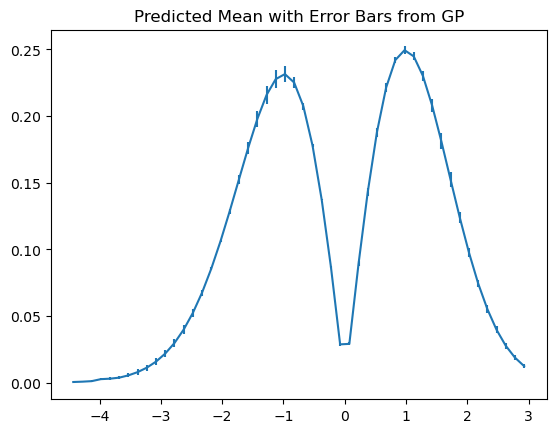

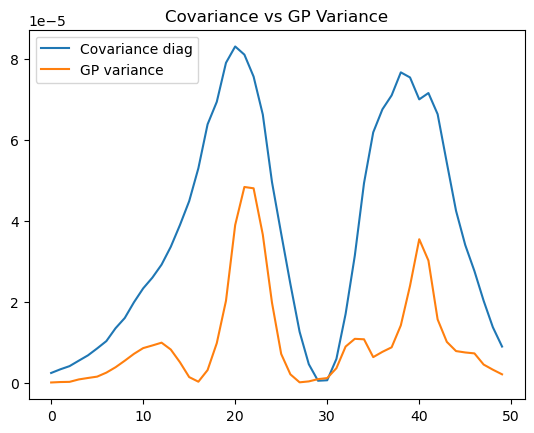

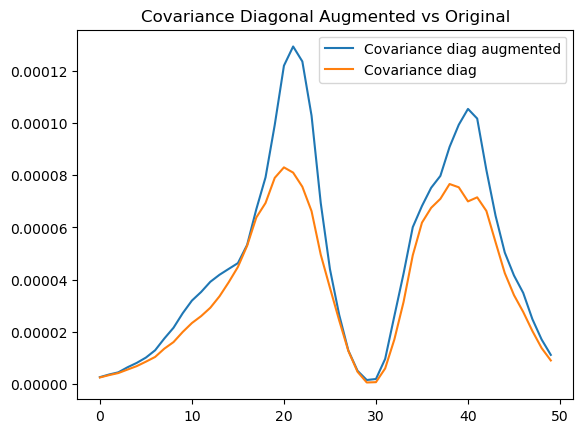

In [86]:
test_cosmo1 = np.array([ 0.1119,  0.7304, -1.3154,  1.8428])  # Example cosmology from SLICS
mu1, var1 = predict_l1norm(test_cosmo1)

plt.figure()
plt.errorbar(snr_rebinned[low_bin_cut:up_bin_cut], mu1, yerr=np.sqrt(var1), label='Predicted mean')
plt.title('Predicted Mean with Error Bars from GP')
plt.show()

plt.figure()
plt.plot(np.diag(cov[low_bin_cut:up_bin_cut, low_bin_cut:up_bin_cut]), label='Covariance diag')
plt.plot(var1, label='GP variance')
plt.legend()
plt.title('Covariance vs GP Variance')
plt.show()

# AUGMENT COVARIANCE MATRIX 
cov_aug1 = cov[low_bin_cut:up_bin_cut, low_bin_cut:up_bin_cut] + np.diag(var1)
icov_aug1 = la.inv(cov_aug1)

plt.figure()
plt.plot(np.diag(cov_aug1), label='Covariance diag augmented')
plt.plot(np.diag(cov[low_bin_cut:up_bin_cut, low_bin_cut:up_bin_cut]), label='Covariance diag')
plt.legend()

plt.title('Covariance Diagonal Augmented vs Original')
plt.show()

### Likelihood

In [87]:
def lnlike(theta, data, cov, norm):

    Om, h, w_0, sigma_8 = theta
    obs_pred = predict_l1norm(theta)[0]
    var_pred = predict_l1norm(theta)[1]
    cov_plus = cov + np.diag(var_pred)  # Augment the covariance matrix with the predicted variance
    icov_plus = la.inv(cov_plus)


    lnlikelihood = -0.5 * norm * np.dot(np.dot((data.reshape(len(data),1)-obs_pred.reshape(len(data),1)).T, icov_plus),(data.reshape(len(data),1)-obs_pred.reshape(len(data),1)))

    return lnlikelihood

def lnprior(theta, Om_min, Om_max, h_min, h_max, w_0_min, w_0_max, sigma_8_min, sigma_8_max):

    Om, h, w_0, sigma_8 = theta
    
    if (Om_min < Om < Om_max and
        h_min < h < h_max and
        w_0_min < w_0 < w_0_max and
        sigma_8_min < sigma_8 < sigma_8_max):
        return 0.0
    
    return -np.inf

def lnpost(theta, data, cov, norm, Om_min, Om_max, h_min, h_max, w_0_min, w_0_max, sigma_8_min, sigma_8_max):

    lp = lnprior(theta, Om_min, Om_max, h_min, h_max, w_0_min, w_0_max, sigma_8_min, sigma_8_max)
    if not np.isfinite(lp):
        return -np.inf
    
    return lp + lnlike(theta, data, cov, norm)

### MCMC

In [88]:
from multiprocessing import cpu_count
ncpu = cpu_count()
norm = 0.947027027027027
Om_min = 0.1019
Om_max = 0.5482
h_min = 0.6034
h_max = 0.8129
w_0_min = -1.9866
w_0_max = -0.5223
sigma_8_min = 0.4716
sigma_8_max = 1.3428

ndim, nwalkers = 4, 8
test_init_params = np.array([ 0.3,  0.7, -1. ,  0.8])
pos = [test_init_params +  1e-4 * np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnpost, args=[predict_l1norm(np.array([0.2905, 0.6898, -1., 0.8364]))[0], cov[low_bin_cut:up_bin_cut, low_bin_cut:up_bin_cut], norm, Om_min, Om_max, h_min, h_max, w_0_min, w_0_max, sigma_8_min, sigma_8_max])
start = time.time()
sampler.run_mcmc(pos, 2000, progress=True)
end = time.time()
multi_time = end - start
print("Multiprocessing took {0:.1f} seconds".format(multi_time))

samples = sampler.chain[:,200:, :].reshape((-1, ndim))

100%|██████████| 2000/2000 [00:49<00:00, 40.29it/s]

Multiprocessing took 49.7 seconds


<>:3: SyntaxWarning: invalid escape sequence '\O'
<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\O'
<>:3: SyntaxWarning: invalid escape sequence '\s'
/var/folders/rb/hr6_gskd33b73srdzr7xdp2w0000gn/T/ipykernel_38840/3200524322.py:3: SyntaxWarning: invalid escape sequence '\O'
  ranges={"$\Omega_m$":[0.1,0.54], "$h$":[0.6,0.8], "$w_0$":[-1.99,-0.2], "$\sigma_8$":[0.4,1.2]})
/var/folders/rb/hr6_gskd33b73srdzr7xdp2w0000gn/T/ipykernel_38840/3200524322.py:3: SyntaxWarning: invalid escape sequence '\s'
  ranges={"$\Omega_m$":[0.1,0.54], "$h$":[0.6,0.8], "$w_0$":[-1.99,-0.2], "$\sigma_8$":[0.4,1.2]})


Removed no burn in


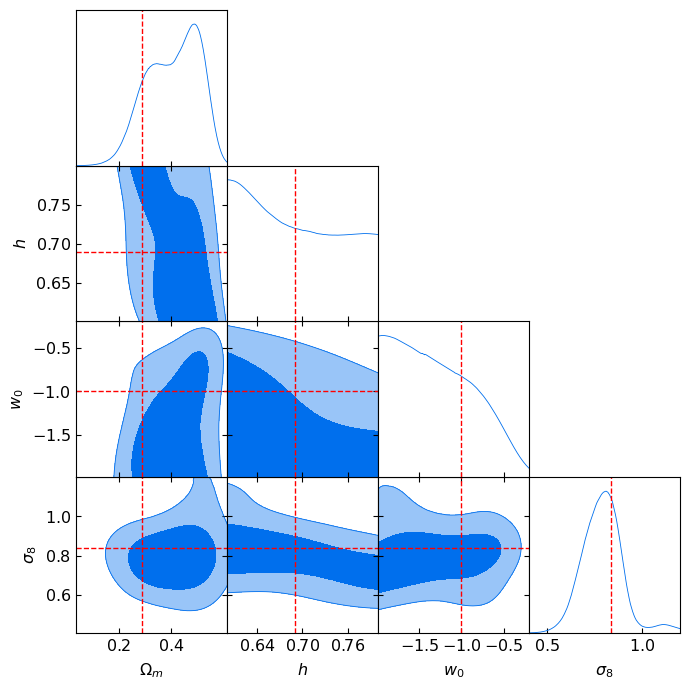

Exception ignored in: <function ResourceTracker.__del__ at 0x106053e20>
Traceback (most recent call last):
  File "/Users/atersenov/miniconda3/envs/lbi/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/Users/atersenov/miniconda3/envs/lbi/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/Users/atersenov/miniconda3/envs/lbi/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x106fcbe20>
Traceback (most recent call last):
  File "/Users/atersenov/miniconda3/envs/lbi/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/Users/atersenov/miniconda3/envs/lbi/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/Users/atersenov/miniconda3/envs/lbi/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [E

In [90]:
samples_sim = sampler.chain[:,1500:, :].reshape((-1, ndim))
MC_samples_sim = MCSamples(samples=samples_sim,names = [r"$\Omega_{m}$",r"$h$", r"$w_0$", r"$\sigma_8$"], 
                                ranges={"$\Omega_m$":[0.1,0.54], "$h$":[0.6,0.8], "$w_0$":[-1.99,-0.2], "$\sigma_8$":[0.4,1.2]})


from getdist import plots, MCSamples, parampriors
truth_values = [0.2905, 0.6898, -1., 0.8364]

g = plots.get_subplot_plotter(width_inch=7)
g.settings.legend_fontsize = 15
g.settings.axes_fontsize = 15
g.settings.axes_labelsize = 15
g.settings.alpha_factor_contour_lines = 1
g.settings.figure_legend_frame = True

# Create the triangle plot
g.triangle_plot([MC_samples_sim], filled=True)

# Iterate over each subplot to add truth lines
for i, ax in enumerate(g.subplots.flatten()):
    if ax is not None:
        # Determine the position of the subplot in the triangle plot to decide on vertical or horizontal lines
        row, col = divmod(i, len(truth_values))
        if row > col:
            # For diagonal plots, add both vertical and horizontal lines as they represent one parameter against itself
            ax.axvline(truth_values[col], color='r', linestyle='--', linewidth=1)
            ax.axhline(truth_values[row], color='r', linestyle='--', linewidth=1)
        elif col == row:
            # For upper triangle, add vertical lines
            ax.axvline(truth_values[col], color='r', linestyle='--', linewidth=1)
        else:
            # For lower triangle, add horizontal lines
            ax.axhline(truth_values[row], color='r', linestyle='--', linewidth=1)


In [ ]:
# save chains
# np.save('emcee_chain_l1_norms_theta15.0_bin5_noPCA_trained_on_50_cosmo.npy', sampler.chain)

## With PCA

1. Data

In [518]:
X = params_new.astype(float)        
Y = l1_rebinned[25:].astype(float)        
noise_per_bin = np.sqrt(cov_diag).astype(float)  
X.shape, Y.shape, noise_per_bin.shape

((25, 4), (25, 80), (80,))

2. Scale the cosmological parameters

In [519]:
x_scaler = StandardScaler()
# x_scaler = MinMaxScaler(feature_range=(-1, 1))
X_scaled = x_scaler.fit_transform(X)

In [562]:
# cut the bins to go from SNR -6, 6 to -2, 2
low_bin_cut = 23
up_bin_cut = 55
Y_cut = Y[:, low_bin_cut:up_bin_cut]

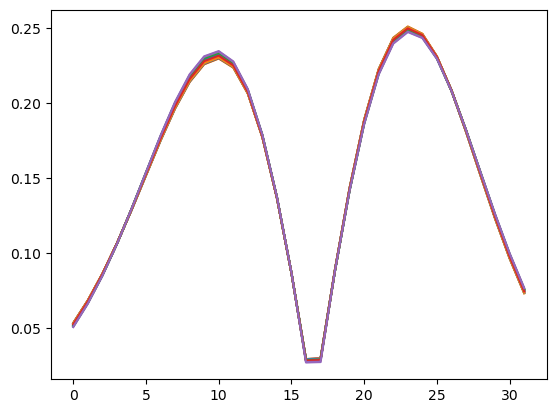

In [563]:
for i in range(Y_cut.shape[0]):
    plt.plot(Y_cut[i], label=f'{i}')

In [604]:
from sklearn.decomposition import PCA

n_components = 7  # for example
pca = PCA(n_components=n_components)
Y_pca = pca.fit_transform(Y_cut)  # shape (50, 10)

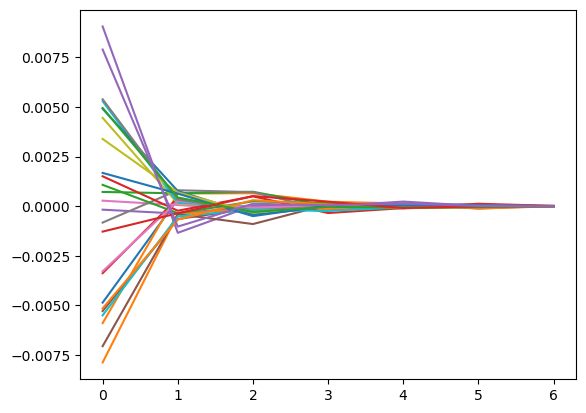

In [605]:
for i in range(Y_pca.shape[0]):
    plt.plot(Y_pca[i], label=f'PCA {i+1}')

Apply PCA to the covariance matrix

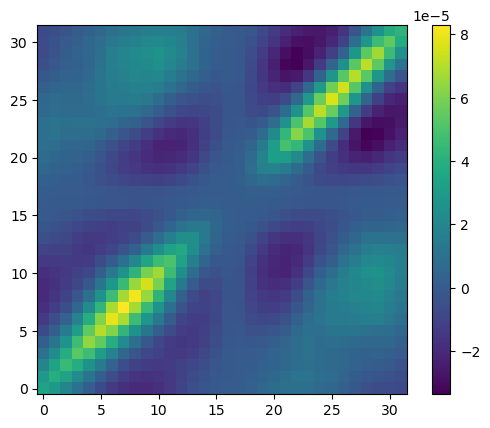

In [606]:
cov_cut = cov[low_bin_cut:up_bin_cut, low_bin_cut:up_bin_cut]
plt.imshow(cov_cut, origin='lower') #, vmin=0,vmax=5000)
plt.colorbar()
plt.show()

In [607]:
cov_pca = pca.components_ @ cov_cut @ pca.components_.T  # shape (n_components, n_components)

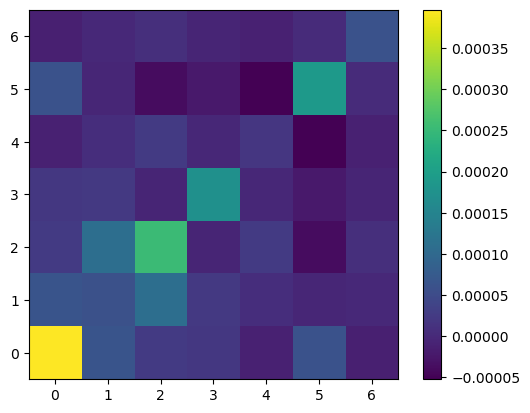

In [608]:
plt.imshow(cov_pca, origin='lower') #, vmin=0,vmax=5000)
plt.colorbar()

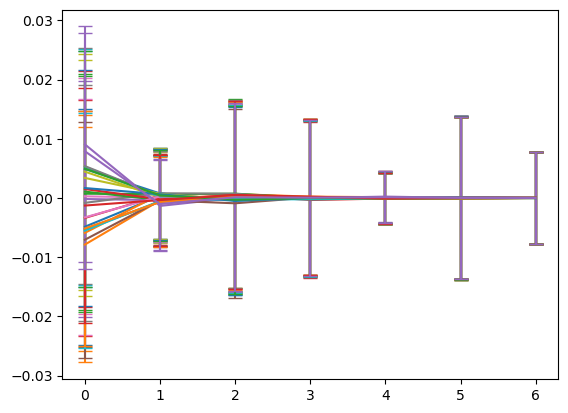

In [609]:
for i in range(Y_cut.shape[0]):
    plt.errorbar(np.arange(n_components), Y_pca[i], yerr=np.sqrt(np.diag(cov_pca)), capsize=5, label='PCA {}'.format(i+1))

In [610]:
alpha_per_component = np.diag(cov_pca) 

Gaussian process regression

In [611]:
def fit_one_bin(X_train, y_train, meas_var):
    """
    Fit a GP on the provided subset (X_train, y_train) for a single bin.
    """
    # kernel = (
    #     C(1.0, (1e-3, 1e3))
    #     * RBF(length_scale=np.ones(X_train.shape[1]), length_scale_bounds=(1e-2, 1e2))
    #     + WhiteKernel(noise_level=1e-2, noise_level_bounds=(1e-2, 1e0))
    # )

    kernel = C(1.0, (1e-2, 1e2)) * RBF(length_scale=np.ones(X_train.shape[1]), length_scale_bounds=(0.01, 100)) #+ WhiteKernel(noise_level=np.sqrt(meas_var), noise_level_bounds='fixed')


    gp = GaussianProcessRegressor(
        kernel=kernel,
        alpha= meas_var,  # np.full(len(y_train), np.sqrt(meas_var)),   # length matches subset
        normalize_y=True,
        n_restarts_optimizer=10,
        random_state=42,
    )
    gp.fit(X_train, y_train)
    return gp

In [612]:
gp_models = Parallel(n_jobs=-1, verbose=10)(
    delayed(fit_one_bin)(X_scaled, Y_pca[:, i], 0.001*alpha_per_component[i]) for i in range(n_components)
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


/Users/atersenov/miniconda3/envs/lbi/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/atersenov/miniconda3/envs/lbi/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 2 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    2.6s remaining:    6.5s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    2.6s remaining:    3.5s
/Users/atersenov/miniconda3/envs/lbi/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarn

In [613]:
print(gp_models[0].kernel_)

2.8**2 * RBF(length_scale=[4.22, 6.26, 4.88, 4.9])


In [614]:
def predict_l1norm_PCA(cosmology, return_var=True):
    x_scaled = x_scaler.transform(np.asarray(cosmology, dtype=float).reshape(1, -1))
    means_pca, vars_pca = [], []
    
    for gp in gp_models:
        if return_var:
            mu, std = gp.predict(x_scaled, return_std=True)
            means_pca.append(mu.item())
            vars_pca.append(std.item() ** 2)
        else:
            means_pca.append(gp.predict(x_scaled)[0])
    
    means_pca = np.array(means_pca)

    if return_var:
        vars_pca = np.array(vars_pca)
        cov_pca = np.diag(vars_pca)
        cov_full = pca.components_.T @ np.diag(vars_pca) @ pca.components_

        return pca.inverse_transform(means_pca), np.diag(cov_full)
    else:
        return pca.inverse_transform(means_pca)

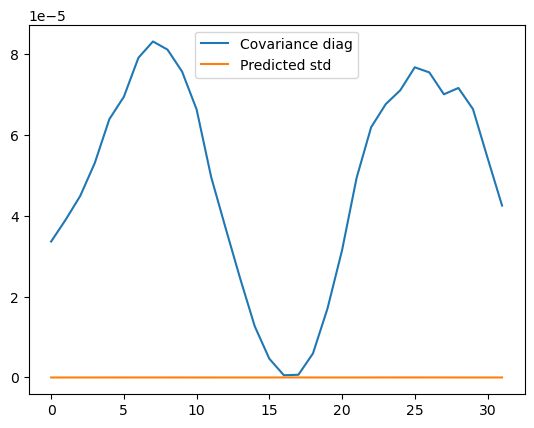

In [615]:
test_cosmo = np.array([0.3, 0.67, -1.0, 0.8])   # Ω_m, h, w_0, s_8
mu, var = predict_l1norm_PCA(test_cosmo)
plt.plot(np.diag(cov_cut), label='Covariance diag')
plt.plot(var, label='Predicted std')
plt.legend()

In [616]:
cov_aug = cov[low_bin_cut:up_bin_cut, low_bin_cut:up_bin_cut] + np.diag(var)
icov_aug = la.inv(cov_aug)

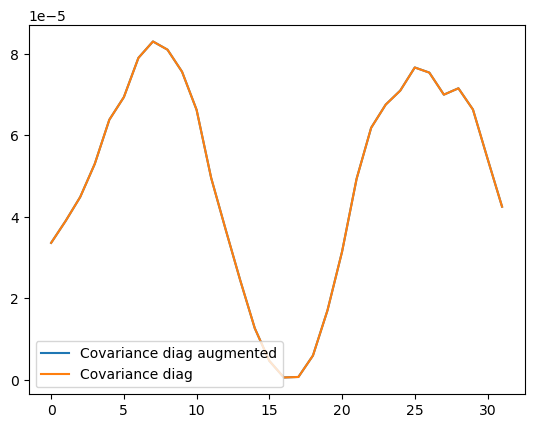

In [617]:
plt.plot(np.diag(cov_aug), label='Covariance diag augmented')
plt.plot(np.diag(cov[low_bin_cut:up_bin_cut, low_bin_cut:up_bin_cut]), label='Covariance diag')
plt.legend()

In [618]:
all_sigma = np.concatenate((slics_sigma,new_sigma), axis=0)

In [619]:
all_sigma.shape

(50,)

Text(0.5, 1.0, 'Predicted histograms for all the cosmologies')

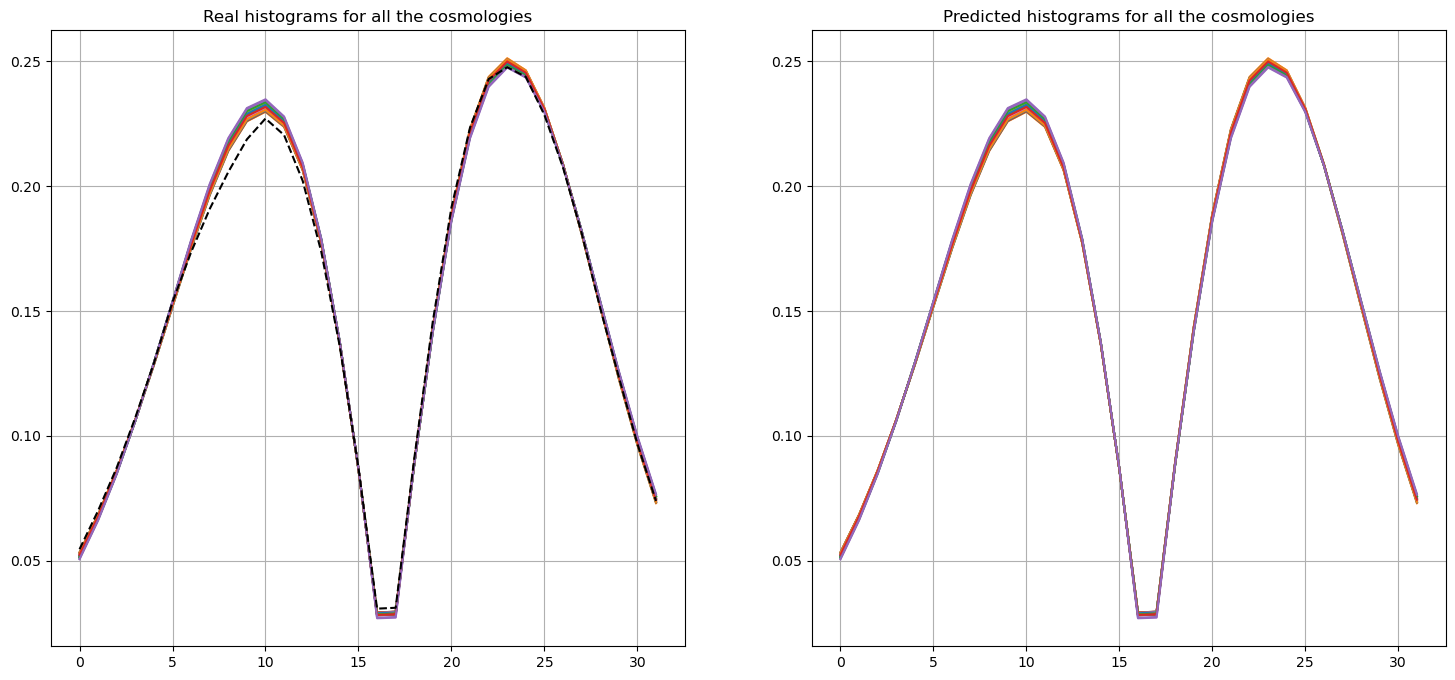

In [620]:
# plot in one subplot the real histograms for all the cosmologies and in another one the ones predicted by GPR
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)

for i in range(Y_cut.shape[0]):
    plt.plot( Y_cut[i], label=f'{i}')
plt.plot(fid_rebinned_mean[low_bin_cut:up_bin_cut], label='sim fid', color='black', linestyle='--')
plt.grid()
plt.title('Real histograms for all the cosmologies')

plt.subplot(1,2,2)
for i in range(Y_cut.shape[0]):
    test_cosmo = predict_l1norm_PCA(params_new[i])[0]
    plt.plot(test_cosmo, label=f'{i}')
plt.grid()
plt.title('Predicted histograms for all the cosmologies')

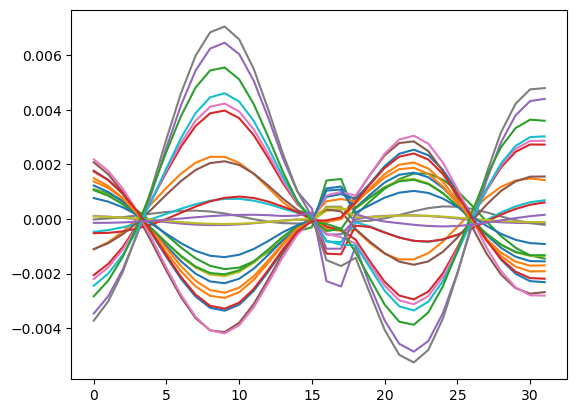

In [621]:
for i in range(Y_cut.shape[0]):
    plt.plot(Y_cut[i]-predict_l1norm_PCA(params_full[i])[0], label=f'{i}')

<ErrorbarContainer object of 3 artists>

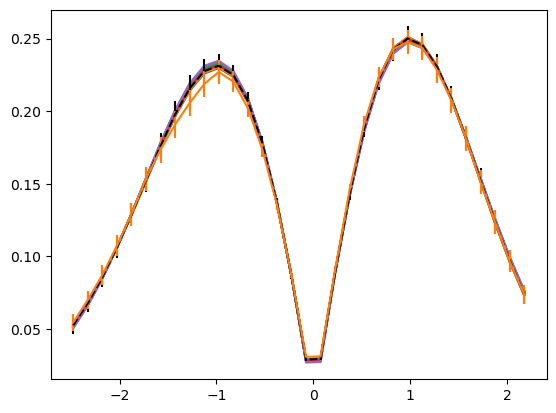

In [622]:
for i in range(Y_cut.shape[0]):
    plt.plot(snr_rebinned[low_bin_cut:up_bin_cut], Y_cut[i], label=f'{i}')
plt.errorbar(snr_rebinned[low_bin_cut:up_bin_cut], predict_l1norm_PCA([0.2905, 0.6898, -1., 0.8364])[0], yerr=np.sqrt(cov_diag[low_bin_cut:up_bin_cut]), label='pred fid', color='black', linestyle='--')
plt.errorbar(snr_rebinned[low_bin_cut:up_bin_cut], fid_rebinned_mean[low_bin_cut:up_bin_cut], yerr=np.sqrt(cov_diag[low_bin_cut:up_bin_cut]), label='sim fid', color='C1')

<ErrorbarContainer object of 3 artists>

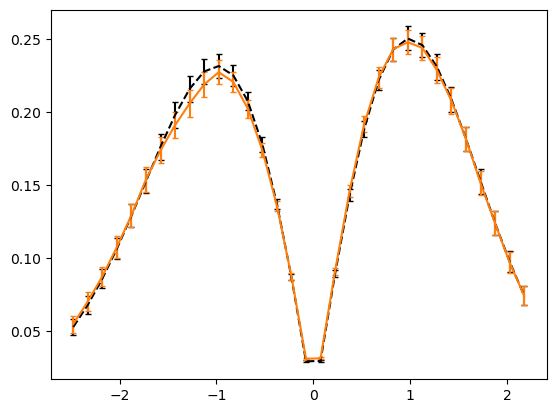

In [623]:
plt.errorbar(snr_rebinned[low_bin_cut:up_bin_cut], predict_l1norm_PCA([0.2905, 0.6898, -1., 0.8364])[0], yerr=np.sqrt(cov_diag[low_bin_cut:up_bin_cut]), label='pred fid', color='black', linestyle='--', capsize=2)
plt.errorbar(snr_rebinned[low_bin_cut:up_bin_cut], fid_rebinned_mean[low_bin_cut:up_bin_cut], yerr=np.sqrt(cov_diag[low_bin_cut:up_bin_cut]), label='sim fid', color='C1', capsize=2)

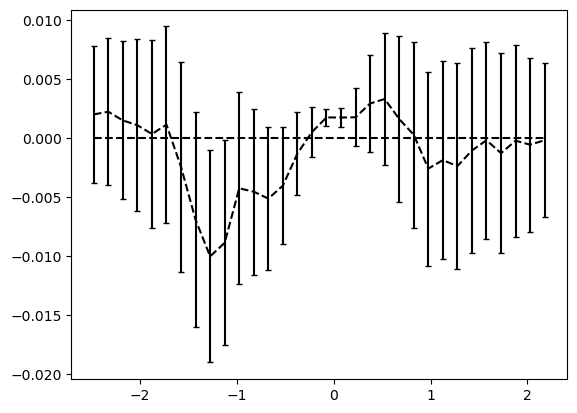

In [624]:
plt.errorbar(snr_rebinned[low_bin_cut:up_bin_cut], fid_rebinned_mean[low_bin_cut:up_bin_cut] - predict_l1norm_PCA([0.2905, 0.6898, -1., 0.8364])[0], yerr=np.sqrt(cov_diag[low_bin_cut:up_bin_cut]), label='pred fid', color='black', linestyle='--', capsize=2)
plt.plot(snr_rebinned[low_bin_cut:up_bin_cut], np.zeros_like(snr_rebinned[low_bin_cut:up_bin_cut]), label='Zero line', color='k', ls='--')

### Validate the GPR on new cosmologies

Text(0.5, 1.0, 'Predicted histograms for all the cosmologies')

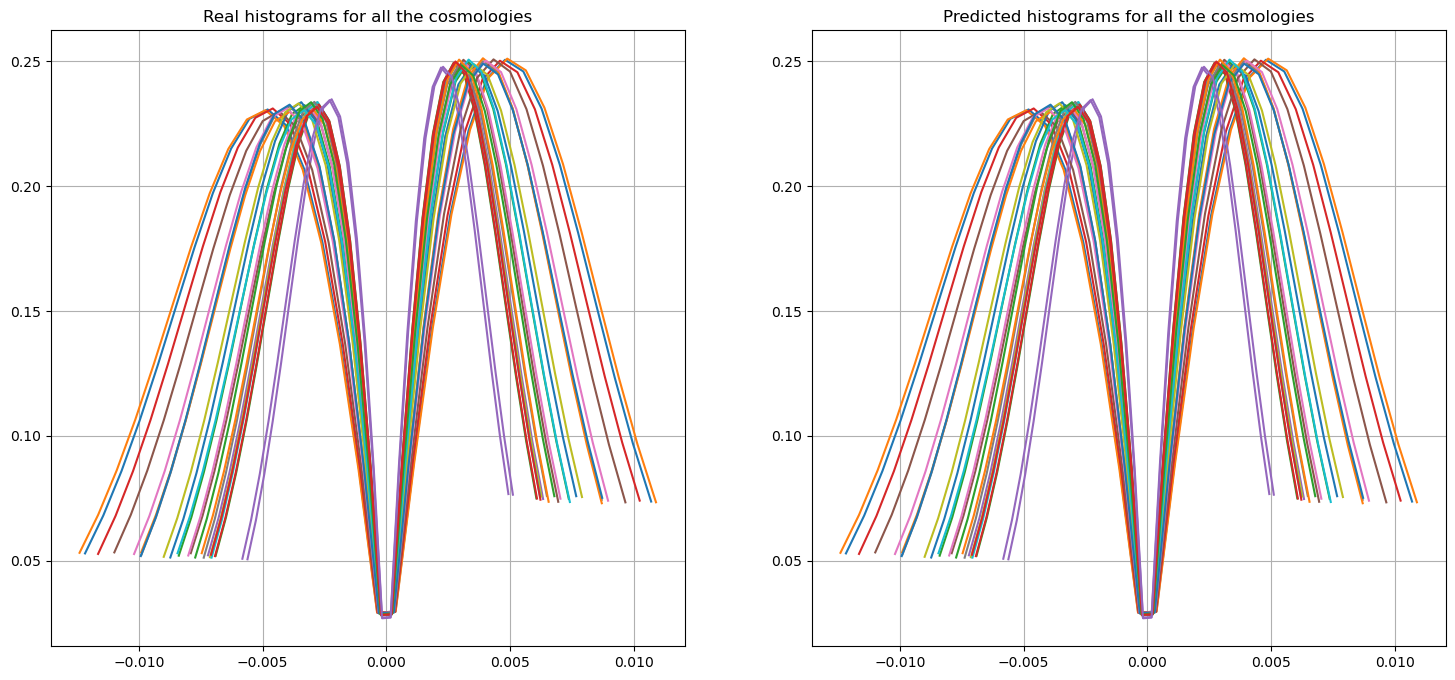

In [625]:
# plot in one subplot the real histograms for all the cosmologies and in another one the ones predicted by GPR
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)

for i in range(new_l1_rebinned.shape[0]):
    plt.plot(snr_rebinned[low_bin_cut:up_bin_cut]* np.sqrt(new_sigma[i]),
        new_l1_rebinned[i][low_bin_cut:up_bin_cut], label=f'{i}')
plt.grid()
plt.title('Real histograms for all the cosmologies')

plt.subplot(1,2,2)
for i in range(Y_cut.shape[0]):
    test_cosmo = predict_l1norm_PCA(params_new[i])[0]
    plt.plot(snr_rebinned[low_bin_cut:up_bin_cut] * np.sqrt(new_sigma[i]),
        test_cosmo, label=f'{i}')
plt.grid()
plt.title('Predicted histograms for all the cosmologies')

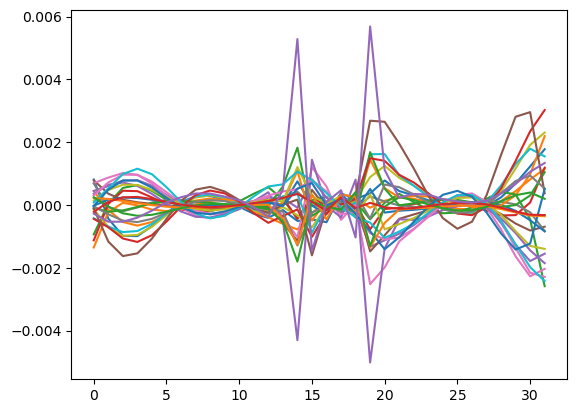

In [626]:
for i in range(new_l1_rebinned.shape[0]):
    plt.plot((new_l1_rebinned[i][low_bin_cut:up_bin_cut]-predict_l1norm_PCA(params_new[i])[0]) * 100/new_l1_rebinned[i][low_bin_cut:up_bin_cut], label=f'{i}')

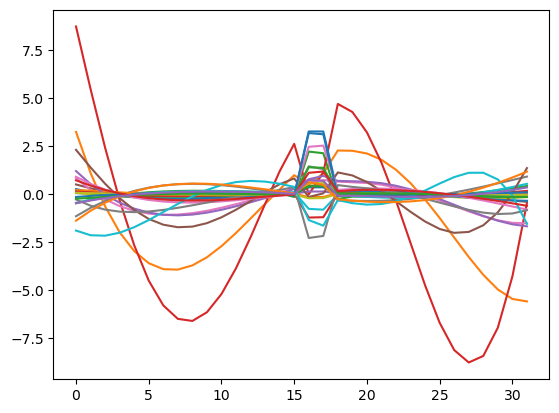

In [627]:
for i in range(25):
    plt.plot((l1_rebinned[i][low_bin_cut:up_bin_cut]-predict_l1norm_PCA(params[i])[0]) * 100/l1_rebinned[i][low_bin_cut:up_bin_cut], label=f'{i}')

### MCMC

In [628]:
def lnprior(theta, Om_min, Om_max, h_min, h_max, w_0_min, w_0_max, sigma_8_min, sigma_8_max):

    Om, h, w_0, sigma_8 = theta
    
    if (Om_min < Om < Om_max and
        h_min < h < h_max and
        w_0_min < w_0 < w_0_max and
        sigma_8_min < sigma_8 < sigma_8_max):
        return 0.0
    
    return -np.inf

def lnlike_PCA(theta, data, icov, norm):

    Om, h, w_0, sigma_8 = theta
    obs_pred = predict_l1norm_PCA(theta)[0]
    lnlikelihood = -0.5 * norm * np.dot(np.dot((data.reshape(len(data),1)-obs_pred.reshape(len(data),1)).T, icov),(data.reshape(len(data),1)-obs_pred.reshape(len(data),1)))

    return lnlikelihood

def lnpost_PCA(theta, data, icov, norm, Om_min, Om_max, h_min, h_max, w_0_min, w_0_max, sigma_8_min, sigma_8_max):

    lp = lnprior(theta, Om_min, Om_max, h_min, h_max, w_0_min, w_0_max, sigma_8_min, sigma_8_max)
    if not np.isfinite(lp):
        return -np.inf
    
    return lp + lnlike_PCA(theta, data, icov, norm)

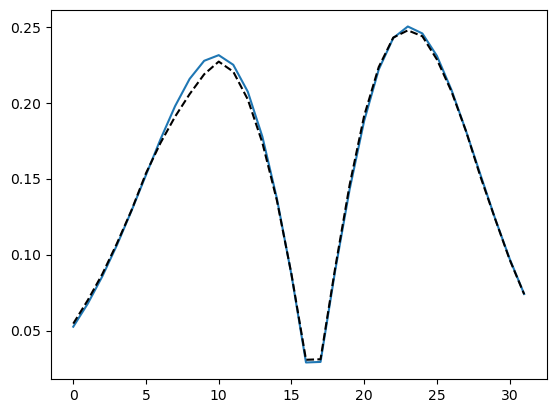

In [629]:
plt.plot(predict_l1norm_PCA(np.array([0.2905, 0.6898, -1., 0.8364]))[0])
plt.plot(fid_rebinned_mean[low_bin_cut:up_bin_cut], label='sim fid', color='black', linestyle='--')

In [630]:
obs = predict_l1norm_PCA(np.array([0.2905, 0.6898, -1., 0.8364]))[0]
# obs = fid_rebinned_mean[low_bin_cut:up_bin_cut]

In [631]:
n_real = 926
n_bins = len(obs)
norm = (n_real-n_bins-2)/(n_real-1)
print(norm)

0.9643243243243244


In [632]:
# norm = 1.0

In [633]:
Om_min = 0.1019
Om_max = 0.5482
h_min = 0.6034
h_max = 0.8129
w_0_min = -1.9866
w_0_max = -0.5223
sigma_8_min = 0.4716
sigma_8_max = 1.3428

In [634]:
ndim, nwalkers = 4, 20  
test_init_params = np.array([ 0.3,  0.7, -1. ,  0.8])
pos = [test_init_params +  1e-3 * np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnpost_PCA, args=[obs, icov_aug, norm, Om_min, Om_max, h_min, h_max, w_0_min, w_0_max, sigma_8_min, sigma_8_max])
sampler.run_mcmc(pos, 6000, progress=True)

samples = sampler.chain[:,200:, :].reshape((-1, ndim))

  0%|          | 0/6000 [00:00<?, ?it/s]

100%|██████████| 6000/6000 [00:32<00:00, 183.31it/s]


<>:3: SyntaxWarning: invalid escape sequence '\O'
<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\O'
<>:3: SyntaxWarning: invalid escape sequence '\s'
/var/folders/rb/hr6_gskd33b73srdzr7xdp2w0000gn/T/ipykernel_43742/2645646718.py:3: SyntaxWarning: invalid escape sequence '\O'
  ranges={"$\Omega_m$":[0.1,0.54], "$h$":[0.6,0.8], "$w_0$":[-1.99,-0.2], "$\sigma_8$":[0.4,1.2]})
/var/folders/rb/hr6_gskd33b73srdzr7xdp2w0000gn/T/ipykernel_43742/2645646718.py:3: SyntaxWarning: invalid escape sequence '\s'
  ranges={"$\Omega_m$":[0.1,0.54], "$h$":[0.6,0.8], "$w_0$":[-1.99,-0.2], "$\sigma_8$":[0.4,1.2]})


Removed no burn in


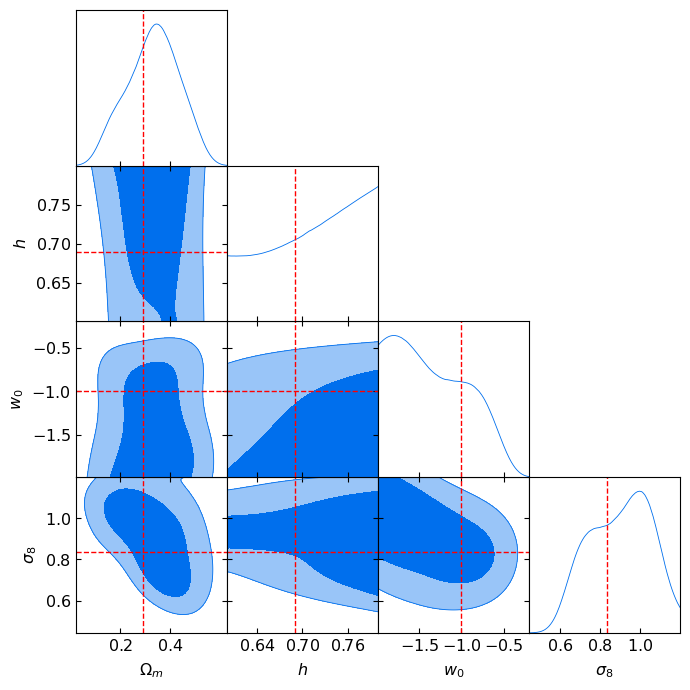

In [641]:
samples_sim = sampler.chain[:,5000:, :].reshape((-1, ndim))
MC_samples_sim = MCSamples(samples=samples_sim,names = [r"$\Omega_{m}$",r"$h$", r"$w_0$", r"$\sigma_8$"], 
                                ranges={"$\Omega_m$":[0.1,0.54], "$h$":[0.6,0.8], "$w_0$":[-1.99,-0.2], "$\sigma_8$":[0.4,1.2]})

from getdist import plots, MCSamples, parampriors
truth_values = [0.2905, 0.6898, -1., 0.8364]

g = plots.get_subplot_plotter(width_inch=7)
g.settings.legend_fontsize = 15
g.settings.axes_fontsize = 15
g.settings.axes_labelsize = 15
g.settings.alpha_factor_contour_lines = 1
g.settings.figure_legend_frame = True

# Create the triangle plot
g.triangle_plot([MC_samples_sim], filled=True)

# Iterate over each subplot to add truth lines
for i, ax in enumerate(g.subplots.flatten()):
    if ax is not None:
        # Determine the position of the subplot in the triangle plot to decide on vertical or horizontal lines
        row, col = divmod(i, len(truth_values))
        if row > col:
            # For diagonal plots, add both vertical and horizontal lines as they represent one parameter against itself
            ax.axvline(truth_values[col], color='r', linestyle='--', linewidth=1)
            ax.axhline(truth_values[row], color='r', linestyle='--', linewidth=1)
        elif col == row:
            # For upper triangle, add vertical lines
            ax.axvline(truth_values[col], color='r', linestyle='--', linewidth=1)
        else:
            # For lower triangle, add horizontal lines
            ax.axhline(truth_values[row], color='r', linestyle='--', linewidth=1)

In [642]:
np.save('chains_l1_norm_theory_80_bins_trained_on_new_25cosmo_added_var_of_GP.npy', sampler.chain[:,5000:, :].reshape((-1, ndim)))

In [ ]:
# save the chains
# np.save('chains_l1_norm_theory_PCA_7_bin_trained_on_new_25cosmo.npy', sampler.chain)

Exception ignored in: <function ResourceTracker.__del__ at 0x10590fe20>
Traceback (most recent call last):
  File "/Users/atersenov/miniconda3/envs/lbi/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/Users/atersenov/miniconda3/envs/lbi/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/Users/atersenov/miniconda3/envs/lbi/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


### Leave-one-out

#### Fit one bin

In [339]:
# # Leave-one-out error (quick diagnostic for bin 0)
from sklearn.model_selection import LeaveOneOut

loo  = LeaveOneOut()
errs = []

for train_idx, test_idx in loo.split(X_scaled):
    X_train, y_train = X_scaled[train_idx], Y[train_idx, 0]
    X_test , y_test  = X_scaled[test_idx],  Y[test_idx , 0]

    gp_loo = fit_one_bin(X_train, y_train, noise_per_bin[0])
    y_pred = gp_loo.predict(X_test)[0]          # scalar

    errs.append(y_pred - y_test)

errs = np.array(errs)
print('Errors: ', errs)
rms  = np.sqrt(np.mean(errs ** 2))
print(f"RMS LOO error (bin 0) = {rms:.4f}")

/Users/atersenov/miniconda3/envs/lbi/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/atersenov/miniconda3/envs/lbi/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/atersenov/miniconda3/envs/lbi/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/atersenov/mi

Errors:  [[ 9.45593301e-08]
 [-7.58958381e-05]
 [ 1.06886829e-06]
 [ 2.23673501e-04]
 [-8.41832638e-07]
 [-2.67476811e-07]
 [-9.04465071e-06]
 [-4.48686461e-07]
 [ 7.25166209e-06]
 [-2.32034331e-06]
 [-1.62558397e-06]
 [ 1.45362648e-06]
 [-7.83908003e-09]
 [ 1.06790237e-06]
 [ 1.06941273e-05]
 [-9.60115796e-05]
 [-4.72276763e-08]
 [-1.95444723e-04]
 [ 1.08389928e-07]
 [-1.56999600e-05]
 [-2.74381477e-07]
 [ 1.19926992e-05]
 [ 3.19288965e-05]
 [-4.57195966e-08]
 [ 1.60315651e-08]
 [ 4.52623182e-06]
 [-1.64590083e-05]
 [ 4.45202437e-07]
 [-1.52617186e-06]
 [ 1.12474494e-06]
 [-1.97999782e-06]
 [ 2.90074785e-07]
 [-1.70728863e-06]
 [ 5.32240778e-08]
 [-1.08290619e-07]
 [-1.04168611e-07]
 [-3.31999846e-06]
 [ 8.69788745e-07]
 [-2.04073002e-06]
 [-5.84055200e-06]
 [ 3.49487777e-06]
 [ 1.12527941e-06]
 [-4.94100272e-07]
 [ 2.05904587e-07]
 [ 7.46815918e-06]
 [ 6.00849861e-07]
 [ 2.81577924e-06]
 [ 5.84296339e-08]
 [-6.35738263e-07]
 [ 2.73604953e-08]]
RMS LOO error (bin 0) = 0.0000


/Users/atersenov/miniconda3/envs/lbi/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


#### Fit all bins in parallel

In [348]:
def loo_rms_for_bin(bin_idx):
    """Return RMS LOO error for a single histogram bin."""
    loocv   = LeaveOneOut()
    errs    = []
    var_bin = noise_per_bin[bin_idx]            # cosmic-variance for this bin

    for train_idx, test_idx in loocv.split(X_scaled):
        # subset the data
        X_train, y_train = X_scaled[train_idx], Y[train_idx, bin_idx]
        X_test , y_test  = X_scaled[test_idx ], Y[test_idx , bin_idx]

        # fit a GP **only on the 49 training examples**
        gp = fit_one_bin(X_train, y_train, var_bin)

        # one-point prediction
        y_pred = gp.predict(X_test)[0]
        errs.append(y_pred - y_test)

    return np.sqrt(np.mean(np.square(errs)))

# ---- run for all 40 bins -----------------------------------
rms_errors_new = np.array(
    Parallel(n_jobs=-1, verbose=5)(
        delayed(loo_rms_for_bin)(i) for i in range(40)
    )
)

# ---- pretty print ------------------------------------------
print("Leave-one-out RMS errors (same units as l1-norm values):")
for i, rms in enumerate(rms_errors):
    print(f"  bin {i:2d}:  {rms:.5f}")
    
# Optional quick sanity check: compare to the expected cosmic variance
print("\nMedian RMS / sqrt(cosmic-variance) ratio:",
      np.median(rms_errors / np.sqrt(noise_per_bin)))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
/Users/atersenov/miniconda3/envs/lbi/lib/python3.13/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/atersenov/miniconda3/envs/lbi/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/atersenov/miniconda3/envs/lbi/lib/python3.13/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as 

Leave-one-out RMS errors (same units as l1-norm values):
  bin  0:  0.00005
  bin  1:  0.00007
  bin  2:  0.00008
  bin  3:  0.00011
  bin  4:  0.00018
  bin  5:  0.00021
  bin  6:  0.00027
  bin  7:  0.00049
  bin  8:  0.00071
  bin  9:  0.00107
  bin 10:  0.00117
  bin 11:  0.00116
  bin 12:  0.00067
  bin 13:  0.00049
  bin 14:  0.00150
  bin 15:  0.00240
  bin 16:  0.00241
  bin 17:  0.00143
  bin 18:  0.00023
  bin 19:  0.00024
  bin 20:  0.00052
  bin 21:  0.00123
  bin 22:  0.00097
  bin 23:  0.00169
  bin 24:  0.00255
  bin 25:  0.00238
  bin 26:  0.00176
  bin 27:  0.00074
  bin 28:  0.00109
  bin 29:  0.00089
  bin 30:  0.00048
  bin 31:  0.00036
  bin 32:  0.00021
  bin 33:  0.00004
  bin 34:  0.00007
  bin 35:  0.00014
  bin 36:  0.00006
  bin 37:  0.00006
  bin 38:  0.00012
  bin 39:  0.00009

Median RMS / sqrt(cosmic-variance) ratio: 0.23228427248586492


/Users/atersenov/miniconda3/envs/lbi/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Exception ignored in: <function ResourceTracker.__del__ at 0x11844be20>
Traceback (most recent call last):
  File "/Users/atersenov/miniconda3/envs/lbi/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/Users/atersenov/miniconda3/envs/lbi/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/Users/atersenov/miniconda3/envs/lbi/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x10754be20>
Traceback (most recent call last):
  File "/Users/atersenov/miniconda3/envs/lbi/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/Users/atersenov/miniconda3/envs/lbi/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/Users/atersenov/miniconda3/envs/lbi/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [E

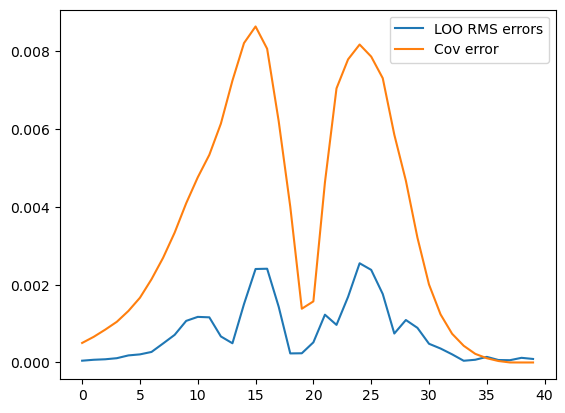

In [352]:
plt.plot(rms_errors_new, label='LOO RMS errors')
plt.plot(np.sqrt(cov_diag), label='Cov error')
plt.legend()